In [ ]:
!pip install qujax

In [ ]:
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

In [ ]:
def expected_kernel(kernel, data1, weights1, data2, weights2):
    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()


def mmd(kernel, data1, weights1, data2, weights2):
    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params


def gaussian_kernel(s1, s2):
    return jnp.exp(-jnp.square(s1 - s2) / bandwidth_sq)


def param_to_mmd(param):
    data_probs = jnp.ones(5000) / 5000
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, data, data_probs)

def param_to_mmd_stochastic(param, batch_size = 200):
    data_probs = jnp.ones(batch_size) / batch_size
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, np.random.choice(data, batch_size), data_probs)

def compute_av_probs(params, burn_in):
    probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(params[burn_in:])
    return probs.mean(axis=0)

In [ ]:
## New method

def G(p,mu_inv,kBT):
  return mu_inv * (p.T @ M_inv @ p - N_d * kBT)

def A_step(q,p,xi,h):
  q = q + h * M_inv @ p
  return q,p,xi

def B_step(q,p,xi,h,force,sigma):
  p = p + h * (force(q))
  return q,p,xi

def O_step(q,p,xi,h,sigma_a):
  term1 = np.exp(-xi*h) * p
  term2 = sigma_a * np.sqrt((1 - np.exp(-2 * xi * h)) / (2 * xi)) * np.random.randn(p.shape[0])
  p = term1 + term2
  return q,p,xi

def D_step(q,p,xi,h,mu_inv,kBT):
  xi = xi + h * G(p,mu_inv,kBT)
  return q,p,xi

def ld_BADODAB(q,p,xi,h,force,mu_inv,kBT,sigma,sigma_a):

    q, p, xi = np.copy(q), np.copy(p), np.copy(xi)
    q, p, xi = B_step(q,p,xi,h/2,force,sigma)
    q, p, xi = A_step(q,p,xi,h/2)
    q, p, xi = D_step(q,p,xi,h/2,mu_inv,kBT)
    q, p, xi = O_step(q,p,xi,h,sigma_a)
    q, p, xi = D_step(q,p,xi,h/2,mu_inv,kBT)
    q, p, xi = A_step(q,p,xi,h/2)
    q, p, xi = B_step(q,p,xi,h/2,force,sigma)

    return q, p, xi

def run_simulation(q0, p0, xi0, Nsteps, h, step_function, force, mu_inv, kBT, sigma, sigma_a, noise_multiplicative_factor):
    import time
    bar_length = 30

    q_traj = [q0]
    p_traj = [p0]
    xi_traj = [xi0]
    cost_vals = []

    q = q0
    p = p0
    xi = xi0

    start_time = time.time()  # Record the start time

    for n in range(Nsteps):
        cost_val, cost_grad = param_to_mmd_and_grad(q_traj[n - 1])
        noise = noise_multiplicative_factor * random.normal(train_keys[n - 1], shape=cost_grad.shape, dtype=jnp.float32)
        cost_grad = cost_grad + noise

        q,p,xi = step_function(q, p, xi, h, force, mu_inv, kBT, sigma, sigma_a)
        cost_vals.append(cost_val)

        q_traj += [q]
        p_traj += [p]
        xi_traj += [xi]

        progress = (n+1) / Nsteps
        filled_length = int(bar_length * progress)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)

        elapsed_time = time.time() - start_time  # Compute the elapsed time
        remaining_time = (elapsed_time / (n + 1)) * (Nsteps - n - 1)  # Estimate the remaining time


        print(f'\rProgress: |{bar}| {progress:.2%} | Iteration: {n+1}/{Nsteps} | Cost: {cost_val:.6f} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {remaining_time:.2f}s', end='')
    print()  # Move to the next line after the progress bar

    total_run_time = time.time() - start_time  # Compute the total run time

    return q_traj, p_traj, xi_traj, cost_vals, total_run_time

Progress: |██████████████████████████████| 100.00% | Iteration: 5000/5000 | Cost: 0.288936 | Elapsed Time: 44.86s | Estimated Remaining Time: 0.00s
Progress: |██████████████████████████████| 100.00% | Iteration: 5000/5000 | Cost: 0.033942 | Elapsed Time: 44.66s | Estimated Remaining Time: 0.00s
Progress: |██████████████████████████████| 100.00% | Iteration: 5000/5000 | Cost: 0.025048 | Elapsed Time: 43.48s | Estimated Remaining Time: 0.00s
Progress: |██████████████████████████████| 100.00% | Iteration: 5000/5000 | Cost: 0.037932 | Elapsed Time: 44.00s | Estimated Remaining Time: 0.00s


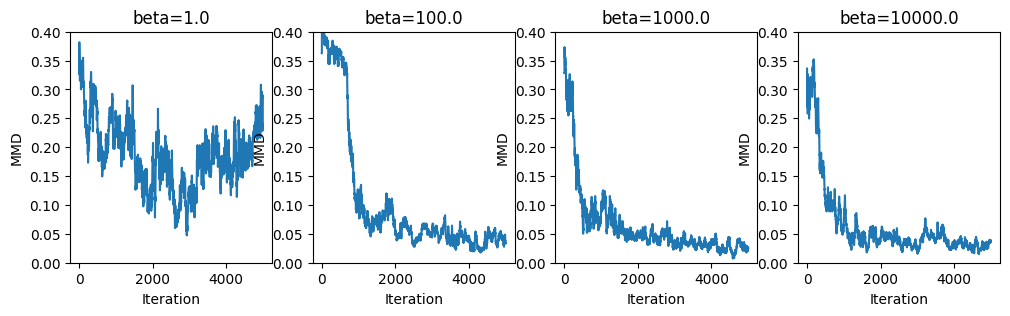

In [ ]:
with open(f'gen_data.pkl', 'rb') as file:
    data = pickle.load(file)

#mu_invs = [0.01, 0.1, 1.0, 10.0, 100.0]
#sigma_as = [0.01, 0.1, 1.0, 10.0, 100.0]
betas = [1.0, 100.0, 1000.0, 10000.0]
noise_multiplicative_factors = [0.0]
#sigmas = [0.1, 0.5, 1.0, 5.0, 10.0]

number_of_data_points = 5000
n_qubits = 8
circuit_depth = 3
init_rad = 0.001 / jnp.pi
n_steps = 5000
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)

## These take awhile for large data sets
# computes pairwise
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
# get bandwidth
bandwidth_sq = 5.7478714 #jnp.median(dist_mat) / 2

# allocate memory
results_beta_stochastic = {}
fig1, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

for i, noise_multiplicative_factor in enumerate(noise_multiplicative_factors):
  for j, beta in enumerate(betas):

    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd_stochastic))
    M, M_inv, N_d = jnp.eye(n_params), jnp.eye(n_params), 1.0
    init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )

    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)

    cost_vals = jnp.zeros(n_steps - 1)

    train_keys = random.split(train_key, n_steps - 1)

    # run the sim
    params, p_traj, xi_traj, cost_vals, total_run_time = run_simulation(
        params[0],
        np.random.randn(n_params),
        0.0,
        n_steps,
        0.1,
        ld_BADODAB,
        lambda q: -param_to_mmd_and_grad(q)[1],
        1., 1./beta, 1., 1., noise_multiplicative_factor)

    ax1[j].plot(cost_vals)
    ax1[j].set_title(f'beta={beta}')#, noise={noise_multiplicative_factor}')
    ax1[j].set_xlabel("Iteration")
    ax1[j].set_ylabel("MMD")
    ax1[j].set_ylim(0, 0.4)

    final_params = params[-1]
    final_st = param_to_st(final_params)

    results_beta_stochastic[(i, j)] = (jnp.square(jnp.abs(final_st.flatten())), cost_vals, total_run_time, params, beta, noise_multiplicative_factor)

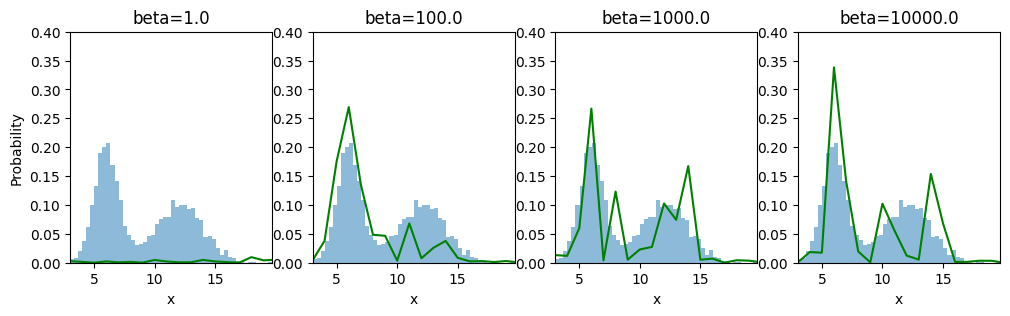

In [ ]:
# Iterate over the results_beta dictionary and plot each set of results
burn_in = 1000
min_data, max_data = data.min(), data.max()
fig2, ax2 = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
for (i,j), (final_st, cost,_, params, beta, noise_multiplicative_factor) in results_beta_stochastic.items():
    ax2[j].hist(data, bins=50, density=True, alpha=0.5)
    #ax2[i,j].plot(final_st, label="Final Parameter", color='orange')
    av_probs = jnp.square(jnp.abs(param_to_st(np.array(params[burn_in:]).mean(0)).flatten()))
    #av_probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(params[burn_in:]).mean(0)
    ax2[j].plot(av_probs, label="Averaged over parameters", color='green')
    ax2[j].set_xlim(min_data, max_data)
    ax2[j].set_ylim(0, 0.4)
    if j == 0:
      ax2[j].set_ylabel("Probability")
    ax2[j].set_xlabel("x")
    ax2[j].set_title(f'beta={beta}')
    #ax2[i,j].legend(fontsize='small')
    #if i == 0:
      #ax2[i, j].set_title(f'beta={beta}')
    #if j == 0:
      #ax2[i, j].set_title(f'noise={noise_multiplicative_factor}')
    #if i == 0 and j == 0:
      #ax2[i, j].set_title(f'beta={beta}, noise={noise_multiplicative_factor}')

plt.show()

In [ ]:
sum(av_probs)

Array(0.99999964, dtype=float32)

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 5000/5000 | Cost: 0.023652 | Elapsed Time: 703.32s | Estimated Remaining Time: 0.00s


(0.0, 0.4)

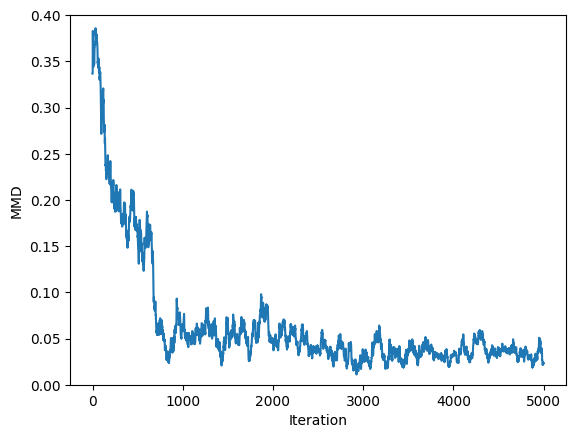

In [ ]:
noise_multiplicative_factor = 10.
beta = 100

gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
M, M_inv, N_d = jnp.eye(n_params), jnp.eye(n_params), 1.0
init_param = random.uniform(
init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
)

params = jnp.zeros((n_steps, n_params))
params = params.at[0].set(init_param)

cost_vals = jnp.zeros(n_steps - 1)

train_keys = random.split(train_key, n_steps - 1)
print('running sim')

# run the sim
params, p_traj, xi_traj, cost_vals, total_run_time = run_simulation(
    params[0],
    np.random.randn(n_params),
    0.0,
    n_steps,
    0.1,
    ld_BADODAB,
    lambda q: -param_to_mmd_and_grad(q)[1],
    1., 1./beta, 1., 1., noise_multiplicative_factor)

plt.plot(cost_vals)
#plt.title(f'beta={beta}, noise={noise_multiplicative_factor}')
plt.xlabel("Iteration")
plt.ylabel("MMD")
plt.ylim(0, 0.4)

(3.0167486667633057, 19.71265411376953)

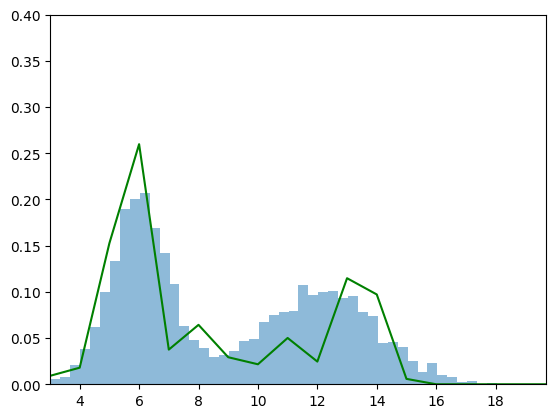

In [ ]:
av_probs = jnp.square(jnp.abs(param_to_st(np.array(params[burn_in:]).mean(0)).flatten()))
plt.hist(data, bins=50, density=True, alpha=0.5)
plt.plot(av_probs, label="Averaged over parameters", color='green')
plt.ylim(0, 0.4)
plt.xlim(data.min(), data.max())

In [ ]:
with open('sgnht_results_beta_noise_before.pkl', 'rb') as file:
    # Load the object from the pickle file
    results_beta_noise = pickle.load(file)

In [ ]:
with open(f'gen_data.pkl', 'rb') as file:
    data = pickle.load(file)

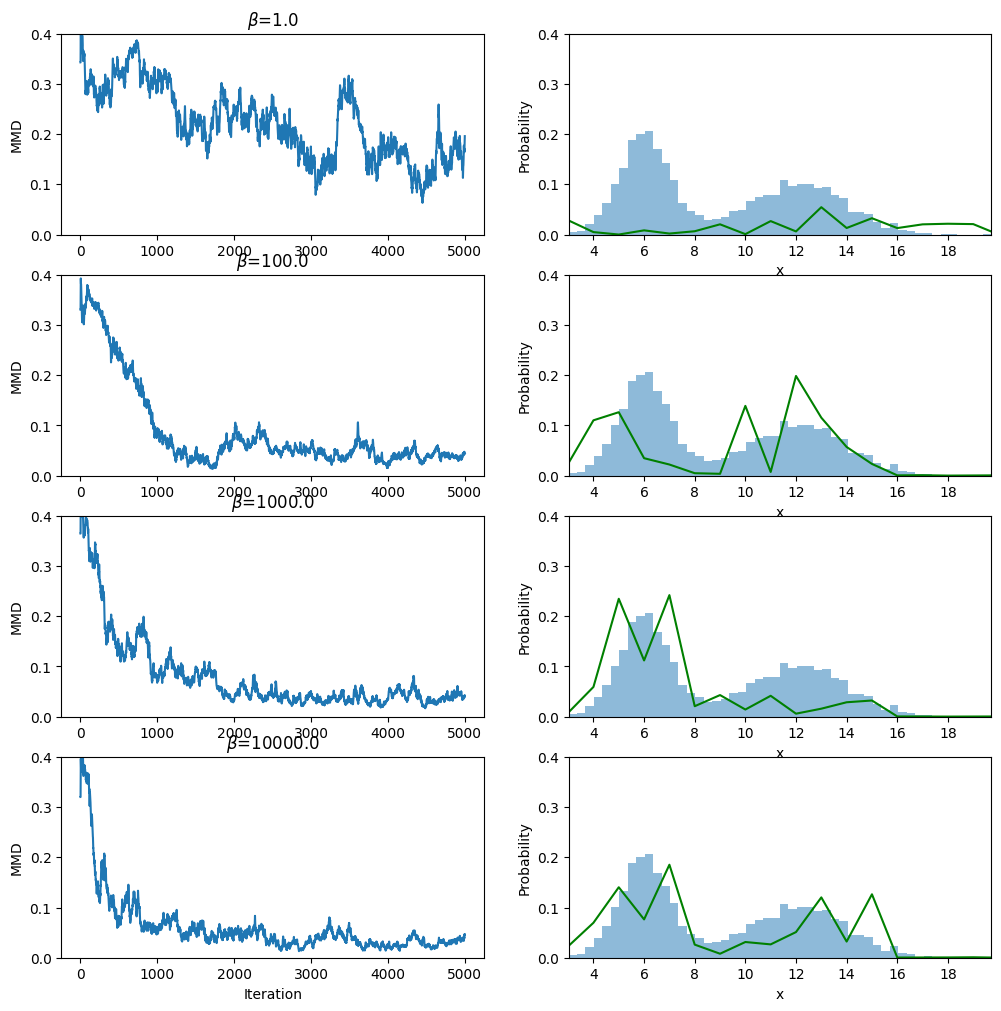

In [ ]:
n_qubits = 8
circuit_depth = 3
burn_in = 1000
gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
for j in [0,1,2,3]:
  _, cost_vals, _, params, beta, _ = results_beta_noise[(0,j)]

  ax[j, 0].plot(cost_vals)
  ax[j, 0].set_title(r'$\beta$' + f'={beta}')
  if j == 3:
    ax[j, 0].set_xlabel("Iteration")
  ax[j, 0].set_ylabel("MMD")
  ax[j, 0].set_ylim(0, 0.4)

  av_probs = jnp.square(jnp.abs(param_to_st(np.array(params[burn_in:]).mean(0)).flatten()))
  ax[j, 1].hist(data, bins=50, density=True, alpha=0.5)
  ax[j, 1].plot(av_probs, label="Bayesian Model Average", color='green')
  ax[j, 1].set_xlim(data.min(), data.max())
  ax[j, 1].set_ylim(0, 0.4)
  ax[j, 1].set_ylabel("Probability")
  ax[j, 1].set_xlabel("x")


In [ ]:
with open(f'gen_data.pkl', 'rb') as file:
    data = pickle.load(file)
with open('sgnht_results_beta_noise_before.pkl', 'rb') as file:
    # Load the object from the pickle file
    results_beta_noise = pickle.load(file)

In [ ]:
gates, qubit_inds, param_inds, n_params = get_circuit(8, 3)
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))

_, _, _, params, _, _ = results_beta_noise[(1,2)]
param_to_st(params[-1])

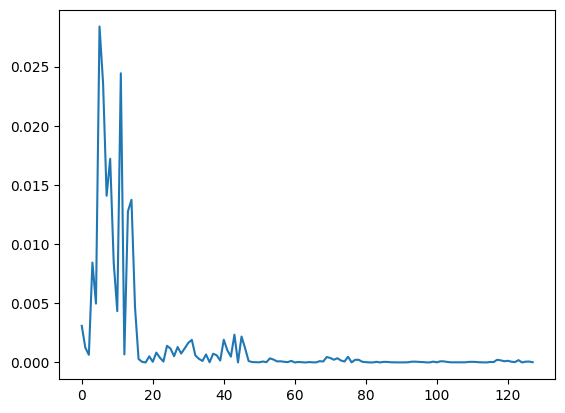

In [ ]:
plt.plot(jnp.square(jnp.abs(param_to_st(params[-1]).mean(0).flatten())))